<h1 style="text-align:center">A star</h1>

En este notebook implementaremos $\text{A}^*$, queremos comparar una heurística admisible trivial con $\text{LoHA}^*$. También implementaremos Dijkstra para realizar comparaciones. Para hacer esto más didáctico, utilizaremos la librería de Open Street Map `osmnx` para cargar el grafo de Bogotá, así mismo, implementaremos funciones para obtener visualizaciones útiles.

### Carga de librerías

In [45]:
import math
import random
import heapq
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt

### Carga del grafo

El grafo asociado a Bogotá tiene el nombre de "*Bogotá Distrito Capital - Municipio*" interno en la librería:

In [3]:
place_name = "Bogotá Distrito Capital - Municipio"
G = ox.graph_from_place(place_name, network_type="drive")

Veamos el número de nodos ($n$) y el de aristas ($m$):

In [4]:
basic_stats = ox.stats.basic_stats(G)
stats = {key: basic_stats[key] for key in ['n', 'm']}
pd.DataFrame.from_dict(stats, orient='index')

0
n   61592
m  154037

Por defecto este grafo cuenta con varios atributos para cada nodo y cada arista. En el caso de los nodos, trae los valores de su longitud ($x$), latitud ($y$) y el número de calles que cruzan ese nodo (*street_count*):

In [5]:
G.nodes.get(list(G.nodes)[0]).keys()

dict_keys(['y', 'x', 'street_count'])

En el caso de las aristas, algunos atributos que nos interesan son su longitud (*length*) dada en metros y su velocidad de tránsito máxima (*maxspeed*) dada en kilómetros por hora (en general).

In [6]:
edge_attributes = ox.graph_to_gdfs(G, nodes=False).columns
print(edge_attributes)

Index(['osmid', 'highway', 'lanes', 'name', 'oneway', 'reversed', 'length',
       'geometry', 'maxspeed', 'junction', 'access', 'bridge', 'ref', 'width',
       'tunnel', 'area'],
      dtype='object')


Visualicemos el grafo:

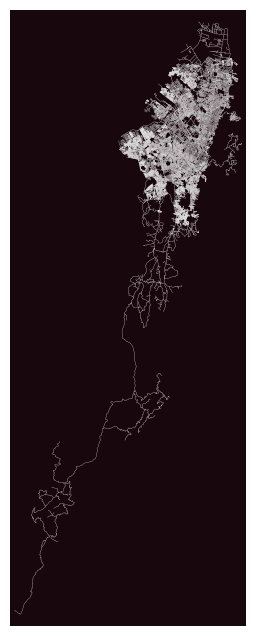

In [7]:
ox.plot.plot_graph(G, bgcolor="#18080e", edge_color="w", edge_linewidth=0.1, node_size=0,);

Como vemos, hay algunos nodos muy al sur de la ciudad que son incluidos, nos concentraremos en un subgrafo más centrado en la parte urbana de la ciudad (filtrado por latitud y longitud):

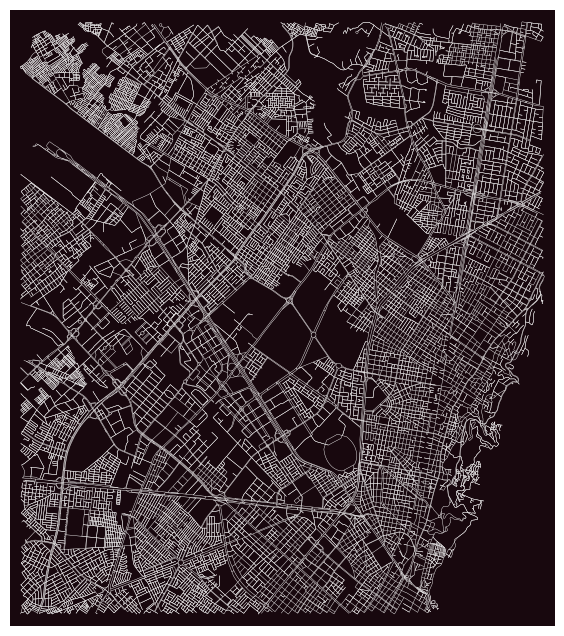

In [8]:
def truncateGraph(G, north=None, south=None, west=None, east=None):
    nodes_to_remove = []

    for node, data in G.nodes(data=True):
        if (north is not None and data['y'] > north) or \
           (south is not None and data['y'] < south) or \
           (east is not None and data['x'] > east) or \
           (west is not None and data['x'] < west):
            nodes_to_remove.append(node)

    G.remove_nodes_from(nodes_to_remove)
    return G 
 
G = truncateGraph(G, west=-74.14604, east = -74.04347, south = 4.60491, north=4.72049)
ox.plot.plot_graph(G, bgcolor="#18080e", edge_color="w", edge_linewidth=0.3, node_size=0);

### Limpieza del grafo

El valor del atributo *maxspeed* de cada arista puede no existir (`None`), puede estar en tipo *string* o puede ser una lista con varios valores. A continuación, arreglamos este inconveniente e incluimos el atributo `weight` que representará el tiempo que se toma en recorrer una arista (distancia sobre velocidad):

In [9]:
for edge in G.edges:
    # Cleaning the "maxspeed" attribute, some values are lists, some are strings, some are None
    maxspeed = 40
    if "maxspeed" in G.edges[edge]:
        maxspeed = G.edges[edge]["maxspeed"]
        if type(maxspeed) == list:
            speeds = [ int(speed) for speed in maxspeed ]
            maxspeed = min(speeds)
        elif type(maxspeed) == str:
            maxspeed = int(maxspeed)
    G.edges[edge]["maxspeed"] = maxspeed
    if "length" not in G.edges[edge] or ("length" in G.edges[edge] and G.edges[edge]["length"] is None):
        G.edges[edge]["length"] = float(ox.distance.great_circle_vec(G.nodes[edge[0]]["y"], G.nodes[edge[0]]["x"], G.nodes[edge[1]]["y"], G.nodes[edge[1]]["x"]))
        
    # Adding the "weight" attribute (time = distance / speed)
    G.edges[edge]["weight"] = (G.edges[edge]["length"] / 1000) / maxspeed

### Funciones para visualizar

In [10]:
def style_unvisited_edge(edge):
    G.edges[edge]["color"] = "#fa001d"
    G.edges[edge]["alpha"] = 0.2
    G.edges[edge]["linewidth"] = 0.5

def style_visited_edge(edge):
    G.edges[edge]["color"] = "#fa001d"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_active_edge(edge):
    G.edges[edge]["color"] = '#ffbfb8'
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_path_edge(edge):
    G.edges[edge]["color"] = "white"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

In [11]:
def plot_graph(step=None, algorithm=None):
    if step is None:
        ox.plot_graph(
            G,
            node_size =  [ G.nodes[node]["size"] for node in G.nodes ],
            edge_color = [ G.edges[edge]["color"] for edge in G.edges ],
            edge_alpha = [ G.edges[edge]["alpha"] for edge in G.edges ],
            edge_linewidth = [ G.edges[edge]["linewidth"] for edge in G.edges ],
            node_color = "white",
            bgcolor = "#18080e",
        )
    else:
        fig, ax = ox.plot_graph(
                G,
                node_size =  [ G.nodes[node]["size"] for node in G.nodes ],
                edge_color = [ G.edges[edge]["color"] for edge in G.edges ],
                edge_alpha = [ G.edges[edge]["alpha"] for edge in G.edges ],
                edge_linewidth = [ G.edges[edge]["linewidth"] for edge in G.edges ],
                node_color = "white",
                bgcolor = "#18080e",
                filepath = f"./frames_{algorithm}/{step:05d}.png",
                save = True,
                show = False, 
                close = False
            )
        plt.close(fig)

In [12]:
def plot_heatmap(algorithm):
    edge_colors = ox.plot.get_edge_colors_by_attr(G, f"{algorithm}_uses", cmap="hot")
    fig, _ = ox.plot_graph(
        G,
        node_size = 0,
        edge_color = edge_colors,
        bgcolor = "#18080e"
    )

### Implementación de algoritmos

Recordemos el algoritmo de $A^*$:

**Entrada:**  
- Grafo/nodos con conexiones  
- Nodo inicial `start`  
- Nodo objetivo `goal`  
- Función heurística `h(n)`

**Salida:**  
- Camino óptimo o falla

1. **Inicializar:**  
   - Abrir lista `open_set = {start}`  
   - Cerrado lista `closed_set = {}`  
   - `g_score[n] = ∞` para todos los nodos, `g_score[start] = 0`  
   - `f_score[n] = ∞` para todos los nodos, `f_score[start] = h(start)`

2. **Mientras** `open_set` no esté vacío:  
   a. Seleccionar nodo `current` en `open_set` con menor `f_score`  
   b. **Si** `current == goal`:  
      - Reconstruir camino y retornarlo  
      
   c. Remover `current` de `open_set`, agregar a `closed_set`  
   d. **Para cada** vecino `neighbor` de `current`:  
      - i. **Si** `neighbor` en `closed_set`: saltar  
      - ii. Calcular `tentative_g = g_score[current] + costo(current, neighbor)`  
      - iii. **Si** `tentative_g < g_score[neighbor]`:  
          - Actualizar `previous[neighbor] = current`  
          - `g_score[neighbor] = tentative_g`  
          - `f_score[neighbor] = g_score[neighbor] + h(neighbor)`  
          - **Si** `neighbor` no en `open_set`:  
              - Agregar `neighbor` a `open_set`

3. **Retornar** falla (no hay camino)

A continuación implementamos el algoritmo:

In [50]:
import time
def a_star(start, goal, heuristic, plot=False, save_frames=False):
    ######## Para visualización #############
    for edge in G.edges: 
        style_unvisited_edge(edge)
    for node in G.nodes:
        G.nodes[node]["size"] = 0
    G.nodes[start]["size"] = 50
    G.nodes[goal]["size"] = 50
    #########################################

    for node in G.nodes:
        G.nodes[node]["visited"] = False
        G.nodes[node]["previous"] = None
        G.nodes[node]["g_score"] = float("inf")
        G.nodes[node]["f_score"] = float("inf")

    step = 0
    G.nodes[start]["g_score"] = 0
    G.nodes[start]["f_score"] = heuristic(start, goal)
    
    pq = [(G.nodes[start]["f_score"], start)]
    while pq:
        _, node = heapq.heappop(pq)

        if node == goal:
            time1 = time.time()
            if plot:
                print("Iteraciones:", step)
                plot_graph()
            return step
        
        if G.nodes[node]["visited"]: 
            continue
        G.nodes[node]["visited"] = True
        
        for edge in G.out_edges(node):
            ######## Para visualización #############
            style_visited_edge((edge[0], edge[1], 0))
            #########################################

            neighbor = edge[1]
            tentative_g_score = G.nodes[node]["g_score"] + G.edges[(edge[0], edge[1], 0)]["weight"] # g_score[current] + costo(current, neighbor)`  
            if tentative_g_score < G.nodes[neighbor]["g_score"]:
                G.nodes[neighbor]["previous"] = node
                G.nodes[neighbor]["g_score"] = tentative_g_score
                G.nodes[neighbor]["f_score"] = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(pq, (G.nodes[neighbor]["f_score"], neighbor))

                ######## Para visualización #############
                for edge2 in G.out_edges(neighbor):
                    style_active_edge((edge2[0], edge2[1], 0))
                #########################################

        ######## Para visualización #############
        if (save_frames) and step % 58 == 0: 
            plot_graph(step=step, algorithm="dijkstra")
        step += 1
        #########################################

Como los pesos que estamos considerando son de tiempo (horas), consideraremos la siguiente heurística que divide la distancia de los puntos entre la velocidad máxima ($60$ kilómetros por hora para el caso del grafo de Bogotá):

In [14]:
def haversine_time(node1, node2):
    # Obtener latitudes y longitudes en radianes
    lat1, lon1 = math.radians(G.nodes[node1]["y"]), math.radians(G.nodes[node1]["x"])
    lat2, lon2 = math.radians(G.nodes[node2]["y"]), math.radians(G.nodes[node2]["x"])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    R = 6378  # Radio de la Tierra en km
    distance_k = float(R * c)
    max_speed=60
    return (distance_k / max_speed)

Adicionalmente, implementamos una función para reconstruir el camino encontrado:

In [15]:
def reconstruct_path(start, goal, algorithm=None, plot=False, save_frames=False):
    ######## Para visualización #############
    algorithm += "_path"
    for edge in G.edges:
        style_unvisited_edge(edge)
    #########################################

    dist, step, total_time = 0, 0, 0
    speeds = []
    curr = goal
    while curr != start:
        prev = G.nodes[curr]["previous"]
        dist += G.edges[(prev, curr, 0)]["length"]
        speeds.append(G.edges[(prev, curr, 0)]["maxspeed"])
        total_time += ((G.edges[(prev, curr, 0)]["length"] / 1000) / G.edges[(prev, curr, 0)]["maxspeed"])
        
        ######## Para visualización ############# 
        style_path_edge((prev, curr, 0))
        if save_frames:
            plot_graph(step=step, algorithm=algorithm)
        if algorithm:
            G.edges[(prev, curr, 0)][f"{algorithm}_uses"] = G.edges[(prev, curr, 0)].get(f"{algorithm}_uses", 0) + 1
        #########################################
        
        curr = prev
        step += 1

    ######## Para visualización #############     
    if plot:
        print(f"Distance: {dist / 1000}km")
        print(f"Avg. speed: {sum(speeds)/len(speeds)}km/h")
        # print(f"Total time: {dist/(sum(speeds)/len(speeds)) * 60}")
        print(f"Total time: {total_time * 60}min")
        plot_graph()
    #########################################
    return total_time * 60

### Aplicación

Elegimos dos nodos al azar:

In [18]:
random.seed(47) # Para reproducir resultados
start = random.choice(list(G.nodes))
goal = random.choice(list(G.nodes))

#### Dijkstra

Encontremos la solución óptima (garantizada) usando Dijkstra ($A^*$) con heurística $0$:

Iteraciones: 8695


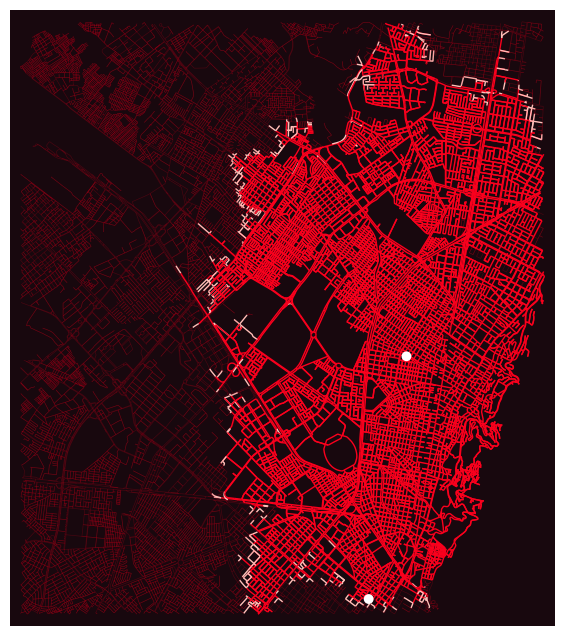

8695

In [34]:
a_star(start, goal, heuristic = (lambda a, b: 0), plot=True, save_frames=True)

Podemos reconstruir el camino encontrado y visualizarlo:

Distance: 6.3814303398041865km
Avg. speed: 38.04347826086956km/h
Total time: 10.019285082401min


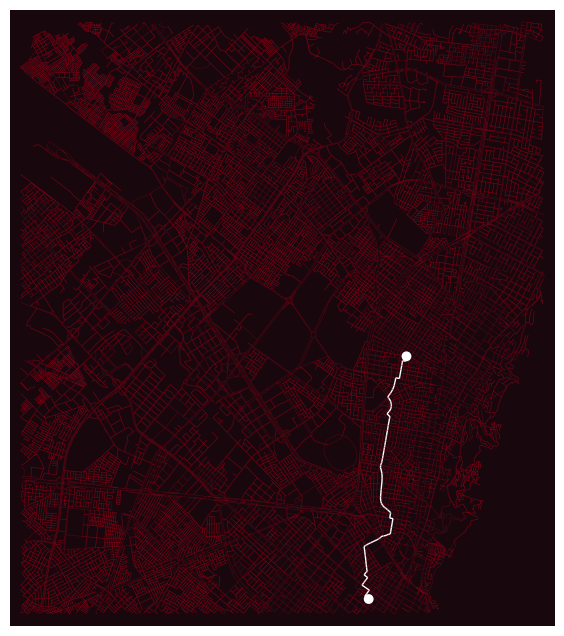

np.float64(10.019285082401)

In [20]:
reconstruct_path(start, goal, plot=True, save_frames=False, algorithm="dijkstra")

#### Heurística Global (Haversine)

Ahora veamos qué pasa utilizando la heurística global `haversine_time`.

Primero veamos que esta heurística es admisible.

**Definición:** Una heurística $h(n)$ es admisible si para todo nodo $n$:
$$h(n) \leq h^*(n)$$
donde $h^*(n)$ es el costo real mínimo desde $n$ hasta el objetivo.

Recordamos que el costo real de cada arista $i$ se define como

$$w[i] = \frac{\text{longitud}[i]}{\text{velocidad}[i]}$$

que representa el tiempo de viaje en la arista $i$.

Proponemos la heurística

$$h_H(n)=\frac{\text{haversine}(n, \text{objetivo})}{\text{velocidad\_máxima}}$$

donde $\text{haversine}(x, y)$ es la distancia en línea recta (sobre la esfera terrestre) entre los nodos $x$, $y$; y $\text{velocidad\_máxima}$ es la velocidad máxima entre todas las aristas.

**Proposición:** La heurística $h_H$ es admisible.

  **Demostración:** Sea $P=\{x_1, x_2, ...,x_k\}$ un camino óptimo entre $n$ y $\text{objetivo}$. La distancia Haversine es menor o igual que cualquier ruta real en el grafo pues en geometría esférica se mantiene la desigualdad triangular:

  $$\text{haversine(n, objetivo)} \leq \sum_{i=1}^k\text{longitud[i]}$$
  
  Además, es claro que 

  $$\text{velocidad\_máxima} \geq \text{velocidad[i]}$$

  para $1\leq i \leq k$.

  Combinando ambas desigualdades,

  $$\frac{\text{haversine(n, objetivo)}}{\text{velocidad\_máxima}} \leq \sum_{i=1}^k\frac{\text{longitud[i]}}{\text{velocidad[i]}} = h^*(n).$$

  Luego la heurística nunca sobrestima el tiempo real mínimo, por lo tanto es admisible.




En este sentido, el algoritmo debe encontrar también una ruta óptima utilizando esta heurística:

Iteraciones: 3027


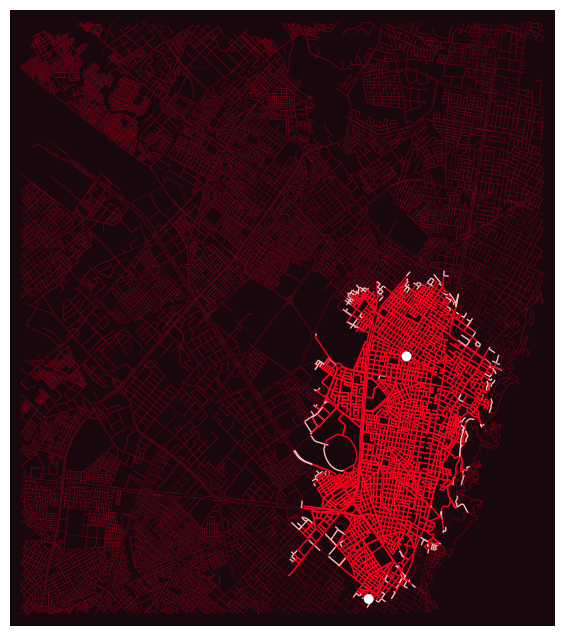

3027

In [32]:
a_star(start, goal, haversine_time, plot=True, save_frames=True)

Distance: 6.3814303398041865km
Avg. speed: 38.04347826086956km/h
Total time: 10.019285082401min


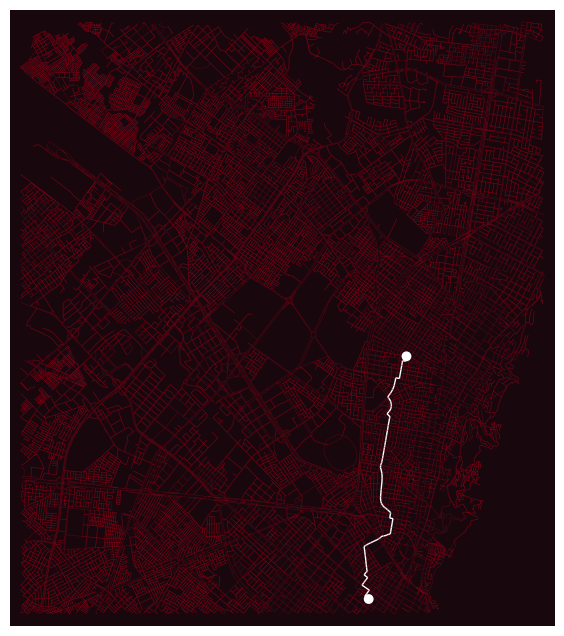

np.float64(10.019285082401)

In [22]:
reconstruct_path(start, goal, plot=True, save_frames=False, algorithm="a_star_haversine")

Vemos que en efecto encuentra una ruta óptima (la misma encontrada por Dijkstra).

#### Heurística local ($\text{LoHA}^*$)

In [23]:
from scipy.spatial import KDTree
import numpy as np

# Preprocesar coordenadas de todos los nodos
nodes = list(G.nodes)
coords = np.array([(G.nodes[n]["x"], G.nodes[n]["y"]) for n in nodes])
kdtree = KDTree(coords)

def get_local_window(node, K_km=5):
    """Obtiene nodos dentro de un radio K_km del nodo dado."""
    point = np.array([[G.nodes[node]["x"], G.nodes[node]["y"]]])
    indices = kdtree.query_ball_point(point, r=K_km/6378.0 * (180/np.pi))[0]  # Convertir km a grados
    return [nodes[i] for i in indices]

In [24]:
def dijkstra_local(s, goal):
    """Implementa Dijkstra sin modificar el grafo G."""
    from queue import PriorityQueue
    
    # Inicializar estructuras
    pq = PriorityQueue()
    visited = set()
    costs = {n: float("inf") for n in G.nodes()}
    costs[s] = 0
    pq.put((0, s))
    
    while not pq.empty():
        current_cost, u = pq.get()
        
        if u == goal:
            return current_cost
            
        if u in visited:
            continue
            
        visited.add(u)
        
        # Explorar vecinos
        for _, v in G.out_edges(u):
            edge_cost = G.edges[(u, v, 0)]["weight"]
            new_cost = current_cost + edge_cost
            
            if new_cost < costs[v]:
                costs[v] = new_cost
                pq.put((new_cost, v))
                
    return float("inf")  # Si no se encuentra camino

In [335]:
local_cache = {}
def local_heuristic(s, goal, K_km=1):
    # if (s, goal) in local_cache:
    #     return local_cache[(s, goal)]
    
    # local_nodes = get_local_window(s, K_km)
    local_nodes = get_local_window(s)
    
    # Si el objetivo está en la ventana, retorna distancia directa
    if goal in local_nodes:
        # local_cache[(s, goal)] = haversine_time(s, goal)
        local_cache[(s, goal)] = dijkstra_local(s, goal)
        return local_cache[(s, goal)]
    
    # Búsqueda local para encontrar el costo mínimo de escapar
    # Usamos Dijkstra dentro de la ventana
    from queue import PriorityQueue
    pq = PriorityQueue()
    visited = set()
    costs = {n: float("inf") for n in local_nodes}
    costs[s] = 0
    pq.put((0, s))
    min_border_cost = float("inf")
    
    while not pq.empty():
        current_cost, u = pq.get()
        if u in visited:
            continue
        visited.add(u)
        
        if u not in local_nodes:
            min_border_cost = min(min_border_cost, current_cost + haversine_time(u, goal))
            continue
        
        for _, v in G.out_edges(u):
            edge_cost = G.edges[(u, v, 0)]["weight"]
            new_cost = current_cost + edge_cost
            if new_cost < costs.get(v, float("inf")):
                costs[v] = new_cost
                pq.put((new_cost, v))
    
    local_cache[(s, goal)] = min_border_cost 
    return min_border_cost 

In [26]:
def combined_heuristic(node, goal):
    h_global = haversine_time(node, goal)
    h_local = local_heuristic(node, goal)
    return h_local #hgk

Iteraciones: 1945


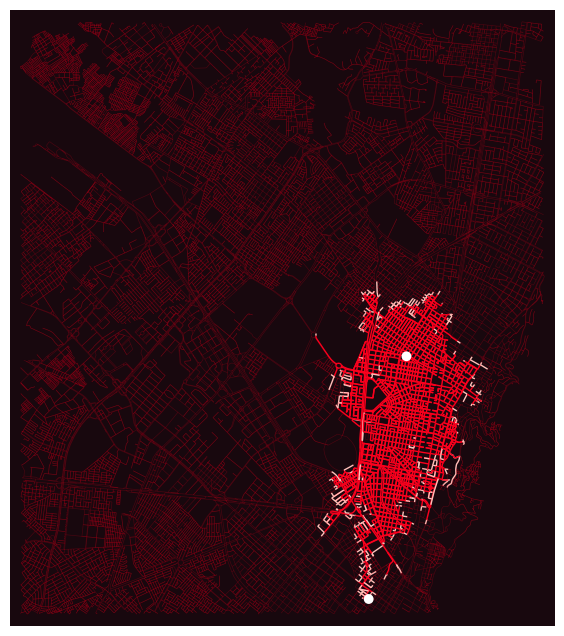

1945

In [43]:
a_star(start, goal, heuristic=combined_heuristic, plot=True, save_frames=False)

Distance: 6.3814303398041865km
Avg. speed: 38.04347826086956km/h
Total time: 10.019285082401min


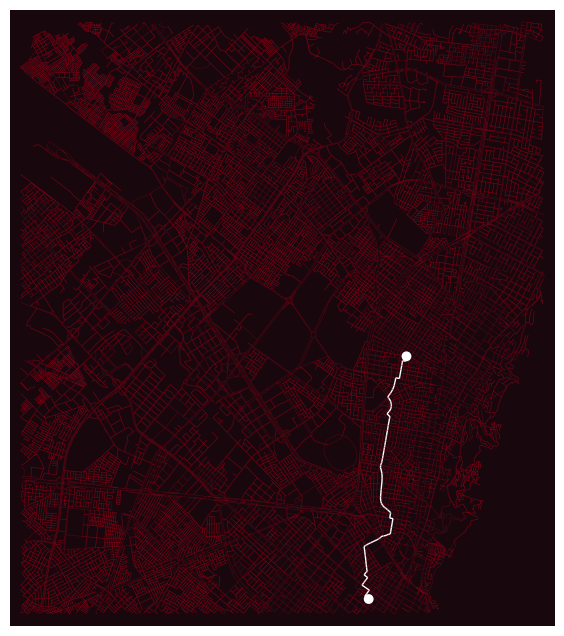

np.float64(10.019285082401)

In [28]:
reconstruct_path(start, goal, plot=True, save_frames=True, algorithm="a_star_local")

Veamos qué tanto se reducen las iteraciones realizando varios experimentos:

In [33]:
t1s, t2s, st1s, st2s, err_rel = [], [], [], [], []

In [34]:
def experiment():
    for i in range(10):
        random.seed(i)
        start = random.choice(list(G.nodes))
        goal = random.choice(list(G.nodes))
        
        st1 = a_star(start, goal, haversine_time, plot=False, save_frames=False)
        time1 = reconstruct_path(start, goal, plot=False, save_frames=False, algorithm="a_star_haversine")
        
        st2 = a_star(start, goal, heuristic=combined_heuristic, plot=False, save_frames=False)
        time2 = reconstruct_path(start, goal, plot=False, save_frames=False, algorithm="a_star_local")

        t1s.append(time1)
        t2s.append(time2)
        st1s.append(st1)  
        st2s.append(st2)
        err_rel.append((time2 - time1) / time1)

experiment()

In [35]:
df = pd.DataFrame({
    "Tiempo hg": t1s,
    "Tiempo hk": t2s,
    "Steps hg": st1s,
    "Steps hk": st2s,
    "Error relativo": err_rel
})
df

Tiempo hg  Tiempo hk  Steps hg  Steps hk  Error relativo
0   9.037461   9.037461      1713       915             0.0
1  13.718734  13.718734      4833      2577             0.0
2  18.467638  18.467638      8038      6317             0.0
3   5.865277   5.865277       963       309             0.0
4  19.031483  19.031483     11626      8662             0.0
5  10.651174  10.651174      2677       966             0.0
6  12.999354  12.999354      5147      2976             0.0
7  24.177737  24.177737     14536     11662             0.0
8   2.602737   2.602737        58        10             0.0
9  13.447691  13.447691      4062      1929             0.0

In [36]:
# Calculamos la reducción promedio en el número de iteraciones
# (st1s - st2s)/st1s nos da la reducción relativa para cada experimento 
# Un valor positivo significa que hk redujo las iteraciones, negativo que las aumentó
reduccion_promedio = np.mean((np.array(st1s) - np.array(st2s)) / np.array(st1s))
reduccion_promedio

np.float64(0.46921821360148364)

En promedio se reduce sobre el 46% de las iteraciones.

### LoHA* (Aproximando hk)

In [371]:
import torch
import torch.nn as nn

# Red neuronal simple (MLP) para predecir el residual local hk
class LocalHeuristicNet(nn.Module):
  def __init__(self, input_dim, hidden_dim=100):
    super(LocalHeuristicNet, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    self.fc3 = nn.Linear(hidden_dim, 1)
  
  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    return x

def load_model(path="local_heuristic_net.pth", inp=2):
  model = LocalHeuristicNet(input_dim=inp)
  model.load_state_dict(torch.load(path))
  model.eval()
  return model

def predict_local_residual(model, state):
  """
  Dado un estado (por ejemplo, sus coordenadas [x, y]), predice el logaritmo de (hk+1)
  y aplica la función inversa para obtener hk.
  """
  # features = torch.tensor([float(G.nodes[state]["x"]), float(G.nodes[state]["y"])], dtype=torch.float32)
  features = torch.tensor([float(G.nodes[state]["x"]), float(G.nodes[state]["y"]), float(haversine_time(state, goal))], dtype=torch.float32)
  features = features.unsqueeze(0)  # Forma (1, input_dim)
  with torch.no_grad():
    pred_log_hk = model(features)
  hk = math.exp(pred_log_hk.item()) - 1  # Inversión de log(hk+1)
  # hk = pred_log_hk.item()
  return hk

model = load_model("modelos/local_heuristic_net_simplifiedGoat.pth", 3)
# model = load_model("modelos/local_heuristic_net.pth")

# Función que combina la heurística global y el residual local predicho
approxs = []
def combined_heuristic_approx(state, goal, model=model):
  h_global = haversine_time(state, goal)
  hk = predict_local_residual(model, state)
  # print(h_global)
  # print(hk)
  # print()\
  approxs.append(hk*100)
  return h_global + abs(hk)*100 #hgk

/var/folders/7g/n66zdk6x2h11lzml1x8_psn80000gn/T/ipykernel_17620/3198133972.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


In [328]:
t1s_, t2s_, st1s_, st2s_, err_rel_ = [], [], [], [], []

In [329]:
def experiment_():
    for i in range(10):
        start = random.choice(list(G.nodes))
        goal = random.choice(list(G.nodes))
        
        st1 = a_star(start, goal, haversine_time, plot=False, save_frames=False)
        time1 = reconstruct_path(start, goal, plot=False, save_frames=False, algorithm="a_star_haversine")
        
        st2 = a_star(start, goal, heuristic=combined_heuristic_approx, plot=False, save_frames=False)
        time2 = reconstruct_path(start, goal, plot=False, save_frames=False, algorithm="a_star_local_ap")

        t1s_.append(time1)
        t2s_.append(time2)
        st1s_.append(st1)  
        st2s_.append(st2)
        err_rel_.append((time2 - time1) / time1)

experiment_()

0.1125168108878967
0.14970319956558087

0.11197075047346858
0.14970117800165927

0.11156078662242554
0.14969946481467789

0.11337913462913386
0.14970433027237529

0.1133225907835264
0.14970516973722958

0.11114719835854296
0.1496988480679895

0.11362297285223175
0.14970606059856184

0.11153069761658302
0.14969946481467789

0.11422318259768954
0.14970633470987993

0.1141546017056263
0.14970724270408775

0.1106900215216112
0.14969711775265782

0.11316178785503571
0.14970463864714856

0.11066866740055871
0.14969617550282988

0.11184370626808394
0.14970038993533086

0.1146266046171705
0.1497076024755759

0.11362297285223175
0.14970606059856184

0.11744500402721453
0.1497172820840682

0.1120286348107506
0.1497000130342343

0.1117248724407989
0.14970003016609956

0.11233256849062548
0.14970145211181318

0.11316178785503571
0.14970463864714856

0.11694344738617964
0.14971604857190646

0.11508291529618558
0.14971013801116184

0.1126854727926898
0.14970285692737795

0.11647493500437373
0.149715

In [330]:
df = pd.DataFrame({
    "Tiempo hg": t1s_,
    "Tiempo hk": t2s_,
    "Steps hg": st1s_,
    "Steps hk": st2s_,
    "Error relativo": err_rel_
})
df

Tiempo hg  Tiempo hk  Steps hg  Steps hk  Error relativo
0  14.088120  14.088120      5723      2969        0.000000
1   2.224589   2.464352        93        27        0.107779
2  10.880040  10.880040      4063      3180        0.000000
3  11.791358  11.791358      2443      2040        0.000000
4  10.044264  10.044264      3032      4319        0.000000
5  14.913630  14.913630      4724      6922        0.000000
6  20.693305  20.693305     11732     10301        0.000000
7  11.550020  11.550020      2421      3944        0.000000
8   2.893561   2.893561       332       520        0.000000
9   9.507610   9.507610       892       317        0.000000

In [331]:
# Calculamos la reducción promedio en el número de iteraciones
# (st1s - st2s)/st1s nos da la reducción relativa para cada experimento 
# Un valor positivo significa que hk redujo las iteraciones, negativo que las aumentó
reduccion_promedio = np.mean((np.array(st1s_) - np.array(st2s_)) / np.array(st1s_))
reduccion_promedio

np.float64(0.025467479167496754)

In [382]:
import time
import seaborn as sns
# Ejecutar experimentos adicionales incluyendo Dijkstra
t_dijkstra, t_haversine, t_local, t_local_ap = [], [], [], []
steps_dijkstra, steps_haversine, steps_local, steps_local_ap = [], [], [], []
sec_dijkstra, sec_haversine, sec_local, sec_local_ap = [], [], [], []
exps = 0

In [ ]:

for i in range(100):
    start = random.choice(list(G.nodes))
    goal = random.choice(list(G.nodes))
    
    # Dijkstra (A* con h=0)
    time0 = time.time()
    st_d = a_star(start, goal, heuristic=lambda x,y: 0, plot=False, save_frames=False)
    time_d = reconstruct_path(start, goal, plot=False, save_frames=False, algorithm="dijkstra")
    time0 = time.time() - time0
    sec_dijkstra.append(time0)

    # A* con heurística haversine
    time0 = time.time()
    st_h = a_star(start, goal, haversine_time, plot=False, save_frames=False)
    time_h = reconstruct_path(start, goal, plot=False, save_frames=False, algorithm="a_star_haversine")
    time0 = time.time() - time0
    sec_haversine.append(time0)

    # A* con heurística local
    time0 = time.time()
    st_l = a_star(start, goal, combined_heuristic, plot=False, save_frames=False)
    time_l = reconstruct_path(start, goal, plot=False, save_frames=False, algorithm="a_star_local")
    time0 = time.time() - time0
    sec_local.append(time0)

    # A* con heurística local aproximada
    time0 = time.time()
    st_l_ap = a_star(start, goal, combined_heuristic_approx, plot=False, save_frames=False)
    time_l_ap = reconstruct_path(start, goal, plot=False, save_frames=False, algorithm="a_star_local_approx")
    time0 = time.time() - time0
    sec_local_ap.append(time0)

    t_dijkstra.append(time_d)
    t_haversine.append(time_h) 
    t_local.append(time_l)
    t_local_ap.append(time_l_ap)
    
    steps_dijkstra.append(st_d)
    steps_haversine.append(st_h)
    steps_local.append(st_l)
    steps_local_ap.append(st_l_ap)
    print(exps)
    exps += 1

0


/var/folders/7g/n66zdk6x2h11lzml1x8_psn80000gn/T/ipykernel_17620/2484056752.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['Dijkstra', 'A* Haversine', 'A* Local', 'A* Local Aproximado'])
/var/folders/7g/n66zdk6x2h11lzml1x8_psn80000gn/T/ipykernel_17620/2484056752.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Dijkstra', 'A* Haversine', 'A* Local', 'A* Local Aproximado'])
/var/folders/7g/n66zdk6x2h11lzml1x8_psn80000gn/T/ipykernel_17620/2484056752.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(['Dijkstra', 'A* Haversine', 'A* Local', 'A* Local Aproximado'])


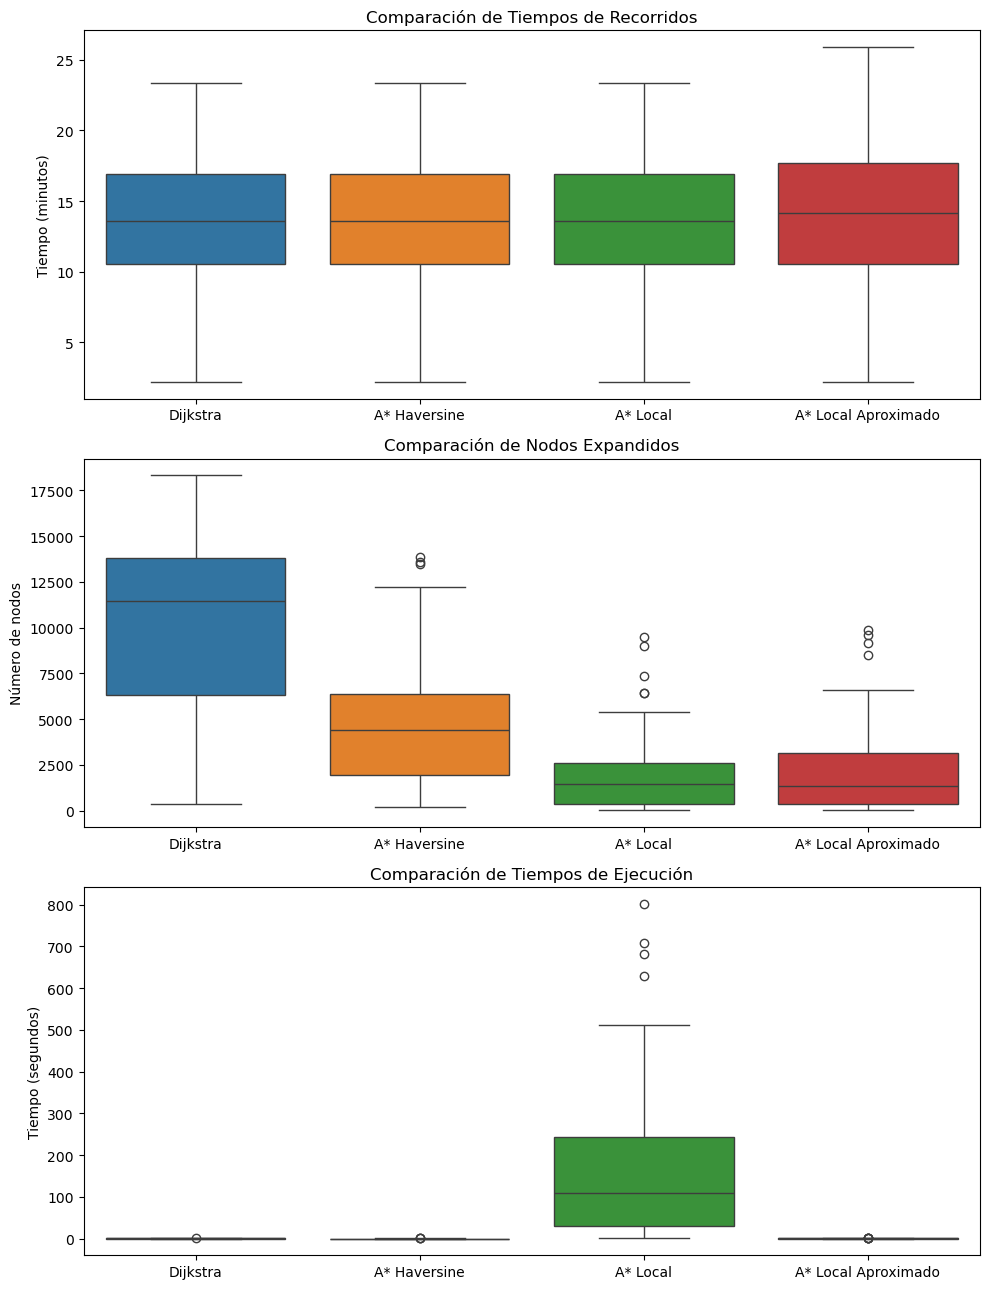


Estadísticas:
Promedio de tiempo (min) - Dijkstra: 13.47, A* Haversine: 13.47, A* Local: 13.47, A* Local Aproximado: 14.02
Promedio de nodos expandidos - Dijkstra: 10205, A* Haversine: 4851, A* Local: 1993, A* Local Aproximado: 2262
Promedio de tiempo de ejecución (s) - Dijkstra: 0.18, A* Haversine: 0.12, A* Local: 173.49, A* Local Aproximado: 0.19


In [339]:
# Crear gráficos comparativos
fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(10,13))

# Gráfico de tiempos recorrido
data_tiempo = [t_dijkstra, t_haversine, t_local, t_local_ap]
sns.boxplot(data=data_tiempo, ax=ax1)
ax1.set_xticklabels(['Dijkstra', 'A* Haversine', 'A* Local', 'A* Local Aproximado'])
ax1.set_title('Comparación de Tiempos de Recorridos')
ax1.set_ylabel('Tiempo (minutos)')

# Gráfico de nodos expandidos
data_nodos = [steps_dijkstra, steps_haversine, steps_local, steps_local_ap]
sns.boxplot(data=data_nodos, ax=ax2)
ax2.set_xticklabels(['Dijkstra', 'A* Haversine', 'A* Local', 'A* Local Aproximado'])
ax2.set_title('Comparación de Nodos Expandidos')
ax2.set_ylabel('Número de nodos')

# Gráfico de tiempos de ejecución
data_ejecucion = [sec_dijkstra, sec_haversine, sec_local, sec_local_ap]
sns.boxplot(data=data_ejecucion, ax=ax3)
ax3.set_xticklabels(['Dijkstra', 'A* Haversine', 'A* Local', 'A* Local Aproximado'])
ax3.set_title('Comparación de Tiempos de Ejecución')
ax3.set_ylabel('Tiempo (segundos)')

# Ocultar el cuarto subplot
ax4.set_visible(False)

plt.tight_layout()
plt.show()

# Calcular y mostrar estadísticas
print("\nEstadísticas:")
print(f"Promedio de tiempo (min) - Dijkstra: {np.mean(t_dijkstra):.2f}, A* Haversine: {np.mean(t_haversine):.2f}, A* Local: {np.mean(t_local):.2f}, A* Local Aproximado: {np.mean(t_local_ap):.2f}")
print(f"Promedio de nodos expandidos - Dijkstra: {np.mean(steps_dijkstra):.0f}, A* Haversine: {np.mean(steps_haversine):.0f}, A* Local: {np.mean(steps_local):.0f}, A* Local Aproximado: {np.mean(steps_local_ap):.0f}")
print(f"Promedio de tiempo de ejecución (s) - Dijkstra: {np.mean(sec_dijkstra):.2f}, A* Haversine: {np.mean(sec_haversine):.2f}, A* Local: {np.mean(sec_local):.2f}, A* Local Aproximado: {np.mean(sec_local_ap):.2f}")

In [379]:
for i in range(100):
    start = random.choice(list(G.nodes))
    goal = random.choice(list(G.nodes))
    
    # Dijkstra (A* con h=0)
    time0 = time.time()
    st_d = a_star(start, goal, heuristic=lambda x,y: 0, plot=False, save_frames=False)
    time_d = reconstruct_path(start, goal, plot=False, save_frames=False, algorithm="dijkstra")
    time0 = time.time() - time0
    sec_dijkstra.append(time0)

    # A* con heurística haversine
    time0 = time.time()
    st_h = a_star(start, goal, haversine_time, plot=False, save_frames=False)
    time_h = reconstruct_path(start, goal, plot=False, save_frames=False, algorithm="a_star_haversine")
    time0 = time.time() - time0
    sec_haversine.append(time0)

    # # A* con heurística local
    # time0 = time.time()
    # st_l = a_star(start, goal, combined_heuristic, plot=False, save_frames=False)
    # time_l = reconstruct_path(start, goal, plot=False, save_frames=False, algorithm="a_star_local")
    # time0 = time.time() - time0
    # sec_local.append(time0)

    # A* con heurística local aproximada
    time0 = time.time()
    st_l_ap = a_star(start, goal, combined_heuristic_approx, plot=False, save_frames=False)
    time_l_ap = reconstruct_path(start, goal, plot=False, save_frames=False, algorithm="a_star_local_approx")
    time0 = time.time() - time0
    sec_local_ap.append(time0)

    t_dijkstra.append(time_d)
    t_haversine.append(time_h) 
    t_local.append(time_l)
    t_local_ap.append(time_l_ap)
    
    steps_dijkstra.append(st_d)
    steps_haversine.append(st_h)
    steps_local.append(st_l)
    steps_local_ap.append(st_l_ap)
    exps += 1

/var/folders/7g/n66zdk6x2h11lzml1x8_psn80000gn/T/ipykernel_17620/2721466747.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['Dijkstra', 'A* Haversine', 'A* Local Aproximado'])
/var/folders/7g/n66zdk6x2h11lzml1x8_psn80000gn/T/ipykernel_17620/2721466747.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Dijkstra', 'A* Haversine', 'A* Local Aproximado'])
/var/folders/7g/n66zdk6x2h11lzml1x8_psn80000gn/T/ipykernel_17620/2721466747.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(['Dijkstra', 'A* Haversine', 'A* Local Aproximado'])


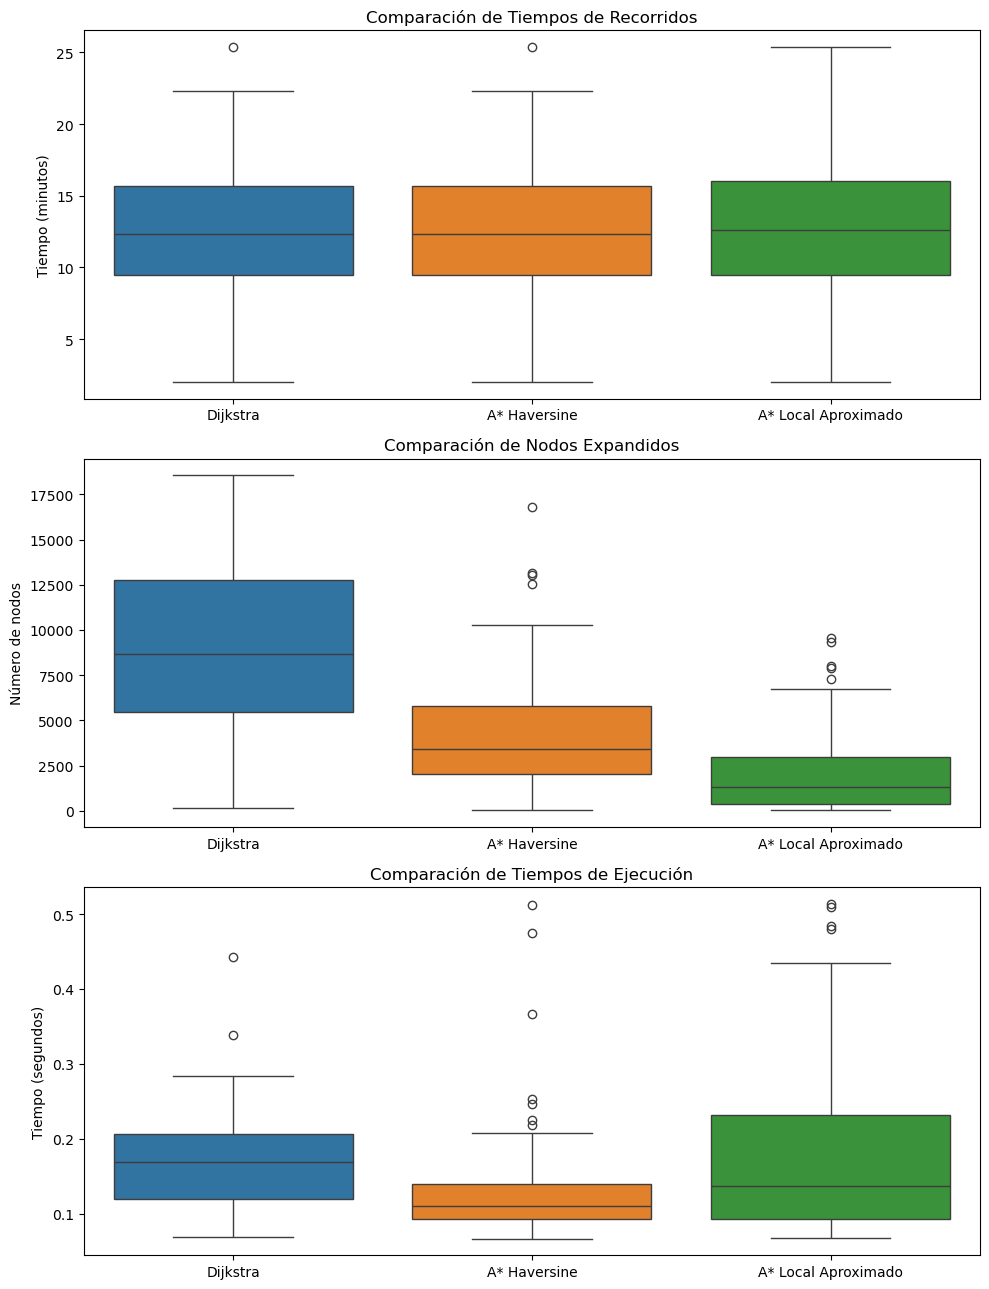


Estadísticas de 105 experimentos:
Promedio de tiempo (min) - Dijkstra: 12.67, A* Haversine: 12.67, A* Local: 7.10, A* Local Aproximado: 12.97
Promedio de nodos expandidos - Dijkstra: 9184, A* Haversine: 4302, A* Local: 141, A* Local Aproximado: 2140
Promedio de tiempo de ejecución (s) - Dijkstra: 0.17, A* Haversine: 0.13, A* Local: nan, A* Local Aproximado: 0.18


/Users/tomas/miniconda3/envs/ia/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tomas/miniconda3/envs/ia/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [380]:
# Crear gráficos comparativos
fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(10,13))

# Gráfico de tiempos recorrido
data_tiempo = [t_dijkstra, t_haversine, t_local_ap]
sns.boxplot(data=data_tiempo, ax=ax1)
ax1.set_xticklabels(['Dijkstra', 'A* Haversine', 'A* Local Aproximado'])
ax1.set_title('Comparación de Tiempos de Recorridos')
ax1.set_ylabel('Tiempo (minutos)')

# Gráfico de nodos expandidos
data_nodos = [steps_dijkstra, steps_haversine, steps_local_ap]
sns.boxplot(data=data_nodos, ax=ax2)
ax2.set_xticklabels(['Dijkstra', 'A* Haversine', 'A* Local Aproximado'])
ax2.set_title('Comparación de Nodos Expandidos')
ax2.set_ylabel('Número de nodos')

# Gráfico de tiempos de ejecución
data_ejecucion = [sec_dijkstra, sec_haversine, sec_local_ap]
sns.boxplot(data=data_ejecucion, ax=ax3)
ax3.set_xticklabels(['Dijkstra', 'A* Haversine', 'A* Local Aproximado'])
ax3.set_title('Comparación de Tiempos de Ejecución')
ax3.set_ylabel('Tiempo (segundos)')

# Ocultar el cuarto subplot
ax4.set_visible(False)

plt.tight_layout()
plt.show()

# Calcular y mostrar estadísticas
print(f"\nEstadísticas de {exps} experimentos:")
print(f"Promedio de tiempo (min) - Dijkstra: {np.mean(t_dijkstra):.2f}, A* Haversine: {np.mean(t_haversine):.2f}, A* Local: {np.mean(t_local):.2f}, A* Local Aproximado: {np.mean(t_local_ap):.2f}")
print(f"Promedio de nodos expandidos - Dijkstra: {np.mean(steps_dijkstra):.0f}, A* Haversine: {np.mean(steps_haversine):.0f}, A* Local: {np.mean(steps_local):.0f}, A* Local Aproximado: {np.mean(steps_local_ap):.0f}")
print(f"Promedio de tiempo de ejecución (s) - Dijkstra: {np.mean(sec_dijkstra):.2f}, A* Haversine: {np.mean(sec_haversine):.2f}, A* Local: {np.mean(sec_local):.2f}, A* Local Aproximado: {np.mean(sec_local_ap):.2f}")

<Axes: ylabel='Count'>

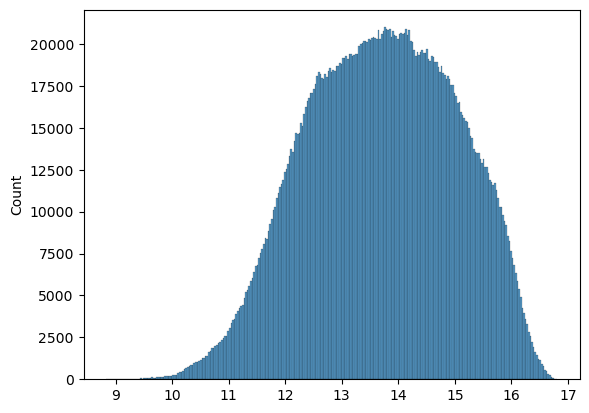

In [360]:
sns.histplot(approxs)

/var/folders/7g/n66zdk6x2h11lzml1x8_psn80000gn/T/ipykernel_17620/967714294.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([f'K={k}km' for k in k_values])
/var/folders/7g/n66zdk6x2h11lzml1x8_psn80000gn/T/ipykernel_17620/967714294.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([f'K={k}km' for k in k_values])


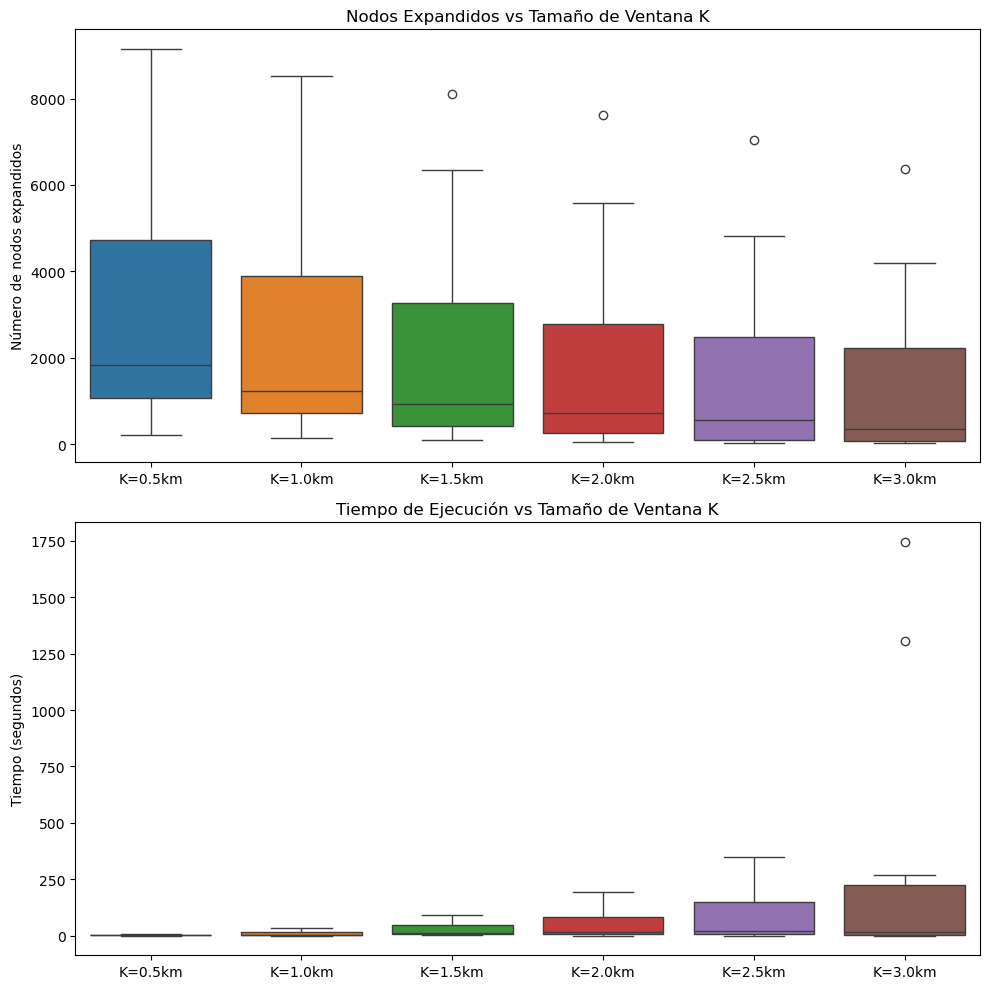


Estadísticas por valor de K:

K = 0.5km:
Promedio de nodos expandidos: 3139
Promedio de tiempo de ejecución: 3.01s

K = 1.0km:
Promedio de nodos expandidos: 2649
Promedio de tiempo de ejecución: 11.16s

K = 1.5km:
Promedio de nodos expandidos: 2302
Promedio de tiempo de ejecución: 28.28s

K = 2.0km:
Promedio de nodos expandidos: 2009
Promedio de tiempo de ejecución: 54.50s

K = 2.5km:
Promedio de nodos expandidos: 1758
Promedio de tiempo de ejecución: 92.41s

K = 3.0km:
Promedio de nodos expandidos: 1523
Promedio de tiempo de ejecución: 346.83s


In [336]:
# Experimentos variando K
k_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
nodes_expanded = {k: [] for k in k_values}
times = {k: [] for k in k_values}

# Realizar experimentos para cada valor de K
for k in k_values:
    for i in range(10):
        random.seed(i)
        start = random.choice(list(G.nodes))
        goal = random.choice(list(G.nodes))
        
        # Redefinir get_local_window con el K actual
        def get_local_window(node, K_km=k):
            point = np.array([[G.nodes[node]["x"], G.nodes[node]["y"]]])
            indices = kdtree.query_ball_point(point, r=K_km/6378.0 * (180/np.pi))[0]
            return [nodes[i] for i in indices]
            
        # Ejecutar A* con heurística local
        start_time = time.time()
        steps = a_star(start, goal, heuristic=combined_heuristic, plot=False, save_frames=False)
        exec_time = time.time() - start_time
        
        nodes_expanded[k].append(steps)
        times[k].append(exec_time)

# Crear gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Gráfico de nodos expandidos vs K
box_data_nodes = [nodes_expanded[k] for k in k_values]
sns.boxplot(data=box_data_nodes, ax=ax1)
ax1.set_xticklabels([f'K={k}km' for k in k_values])
ax1.set_title('Nodos Expandidos vs Tamaño de Ventana K')
ax1.set_ylabel('Número de nodos expandidos')

# Gráfico de tiempos de ejecución vs K
box_data_times = [times[k] for k in k_values]
sns.boxplot(data=box_data_times, ax=ax2)
ax2.set_xticklabels([f'K={k}km' for k in k_values])
ax2.set_title('Tiempo de Ejecución vs Tamaño de Ventana K')
ax2.set_ylabel('Tiempo (segundos)')

plt.tight_layout()
plt.show()

# Mostrar estadísticas
print("\nEstadísticas por valor de K:")
for k in k_values:
    print(f"\nK = {k}km:")
    print(f"Promedio de nodos expandidos: {np.mean(nodes_expanded[k]):.0f}")
    print(f"Promedio de tiempo de ejecución: {np.mean(times[k]):.2f}s")
